# Chapter 03 - Classification 

In the first chapter the author mentioned that the most common form of supervised learning tasks are regression (where we are prediciting continuous variables) and classification (prediciting classes). In the previous chapter we explored a regression task, where we looked at prediciting the house prices using several types of algorithms, such as linear regression, decision trees and random forests. In this chapter, we are going to look at classification tasks. 

### MNIST Dataset 

For this chapter we will be using the MNIST dataset, this is a dataset of 70 thousand labelled images of handwritten numbers. The set has been studied so much that it is often called the "hello world" of machine learning (thinking back to when I did my first hello world when I started to learn coding). Whenever people come up with new classification algorithms, the first thing they do is test it on the MNIST dataset to see how it fairs. Anyone who does machine learning or is learning machine learning has tackled or is going to tackle this dataset at some point!!!!

Scikit-learn provides many helper funtions to download popular datasets such as the MNIST dataset, the following code fetches the dataset for us. 

In [1]:
from sklearn.datasets import fetch_openml 

mnist = fetch_openml('mnist_784', version=1, as_frame = False) # we need to set the as_frame = false as skikit learn has updated

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets that are loaded in my scikit learn generally have a similar dictionary structure that include the following. 

- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one colum per feature 
- A target key that contains all of the labels for each of the instances

Let's look at these arrays below

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70 thousand iages and each image is made up of 784 features. This is because each image is 28 x 28 pixels and each feature is simply representing the pixels intensity from 0 (which is white) to 255 (which is black). Lets take a look at one of the digits on our dataset. All we need to do is grab an instances feature vector (we know what these are now) and reshape it into the 28 x 28 array, and thi display it using Matplotlibs imshow() function. 

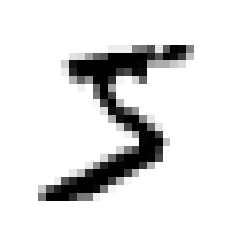

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

first_digit = X[0]

first_digit_image = first_digit.reshape(28, 28)

plt.imshow(first_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

Perfect it's a five, note that the label is a string. Most ML algorithms expect numbers to be fed into them lets cast y to an integer. 

In [7]:
# converting all of the strings into integers
y = y.astype(np.uint8)

Remember that before we go onto analyse the dataset we need to create a test set. The MNIST dataset is actually already split into a training and test split (the first 60,000 are training and the last 10,000 is testing) so lets create our test train split. 

In [8]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

It should be noted that the dataset is already shuffled which is good because it means that the cross validation folds should contain similar amount of each digit, as well as this machine learning algorithms don't tend to like being fed instances that are too similar one after eachother, shuffling the dataset ensures this wont happen. 

### Training a Binary Classifer

Let us go through a simpler problem for now, and simply try and identify one digit - for example the number 5 we have just looked at !!!! This "5-detector" lol will be an example of what is called a **binary classifer**, capable of distinguishing between just two classes (5 and not 5). Lets create the target vectors for the classification task.


In [9]:
y_train_5 = (y_train == 5) # setting the 5 labels to be the 5 training set
y_test_5 = (y_test == 5)

Now lets pick a classifier and train it. A good place to start is with a **stochastic gradient descent (SGD) classifier** using Scikitlearns SDGClassifer class. This has the advantage of being able to handle very large datasets efficiently. This is in part because the SGD classifier deals with training instances independently, one at a time (this also makes the SDG classifier really good for online learning) as we will see later. Lets create an SGD classifier and train it on the whole training dataset. 

In [10]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # Either it is a 5 or it isn't a 5

SGDClassifier(random_state=42)

NOTE: The stochastic gradient descent relies on randomness during training (hence the name "stochastic"). If we want repoducible results, we need to set the random seed. 

Now lets use it to classify an image

In [11]:
sgd_clf.predict([first_digit]) # note that this is in [] 

array([ True])

YAY, the classifier guesses that the image is a 5 (True). This looks like its guessed right in this case. Now let's evaluate this models performance overall.

### Performance Measure

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will be spending a large part of this chapter covering the this topic. There are many perfromance measures at our disposal, so grab a coffee and get ready to learn some new concepts and some new acronyms!!!!!!

### Measuring Accuracy Using Cross-Validaton 

A great way to evaluate a model is to use cross validation, just like we did in chapter 2.

However sometimes we will need more control over the cross validation process than what scikit-learn provides to us. In these cases, you can implement cross validation by hand. The following code does roughly the same thing as scikitlearns cross_val_score() function and it prints the same result. 

Lets take this oppourtunity to understand the inner mechanics of how the cross val score function work.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5): # splitting the data training set and label
    clone_clf = clone(sgd_clf) # create a clone of the sgd classifier
    X_train_folds = X_train[train_index] # assign the value to the x train set 
    y_train_folds = y_train_5[train_index] # assign the value to the y train set
    X_test_fold = X_train[test_index] # assign the value to the x test set 
    y_test_fold = y_train_5[test_index] #assign the value to the y test set

clone_clf.fit(X_train_folds, y_train_folds)
y_prediction = clone_clf.predict(X_test_fold)
number_correct = sum(y_prediction == y_test_fold)
print(number_correct / len(y_prediction))

0.96785


The StratifiedKFold class performs stratified sampling to produce folds that contan a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone classifier on the training folds and makes predictions on that test. It then counts the number of correct predictiions and outputs the ratio of correct predictions

Now lets use the cross_val_score() function using our SDG classifier using K fold cross validation with three folds. Remeber that K fold cross validation means splitting the the training set into K folds (in this case 3), then making predictions and evaluating them on each fold using a model trained on remaining folds. 

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

WOW! above 90% accuracy (the ratio of correct predictions) on all cross validation folds! This looks amazing, but sadly this isn't the case, before we get too excited lets look at a really dumb classifier that simply just classifies everything in this dataset as "not a 5".

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can we guess the models accuracy??? Lets have a look!

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Lol thats funny, we have around 90% accuracy by simply just saying everything is a 5. This is becuase only about 10% of the MNIST dataset is a 5. So if we always guess that it is not a 5, we will still get a really high score. 

This demonstrates why accuracy is generally not a great performance metric for classifiers. Especially when we are dealing with skewed datasets (when one of the classes is much more fequent than the other).

### Confusion Matrix 

A much better way to evaluate the performance of a classifier is the use a confusion matrix. The general idea for the confusion matrix is to count the number of times instances of a class A are classified as class B. For example, to know how many times the classifier confused images of 5s as 3s we would look on the 5th row an the 3rd column of the confusion matrix. 

To compute the confusion matrix, we first need a set of predictions, so that they can be compared with the actual targets. For this we use the cross_val_predict() function. 

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like cross_val_score(), cross_val_predict() preforms Kfold cross validations but instead of returning evaluation scores, it returns the predictions made on each test fold. This means that we get a clean predicition for each instance in the training set (the term 'clean' means that the predicition was made by the model on an instance that it has not seen before in training). 

Now that we are ready to get to the confusion matrix we can get this by using the confusion_matrix() function. Just pass the target class and the predicted class into the function.

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predictions)

array([[53892,   687],
       [ 1891,  3530]])

Each row in the confusion matrix represents and **actual** class, while each column represents a **predicted** class. The first row of this matrix considers the non-5 images (the negative class). 53892 of them were correctly predicted as negative, while the remaining 687 were wrongly classified as 5s (flase positive) when they actually were not 5s. On the second row is the positive class (images of 5), 1891 were falsely identified as not 5s (false negative) when in fact there were and 3530 images were correctly identified as 5s (true positive) in the cross validation. A perfect classifier would only have true positives and true negatives while having nonzero values on the main diagonal (top left to bottom right). 

In [18]:
y_train_perfect_predicitions = y_train_5 # we are pretending that we have reached perfect predictions
confusion_matrix(y_train_5, y_train_perfect_predicitions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes we may prefer a more concise metric. An interesting metric is the **precision** of the classifier, this is the accuracy of positive predicitions, and is defined as:

Equation 3.1 Precision

precision $= \frac{TP}{TP + FP}$

TP is the true positive rate and FP is the false positive rate. A trivial way to have 100% precision is to make only one prediction and make sure that predicition is correct (precision = 1/1 = 100%). But this would not be very useful would it!!! So typically we use precision in conjunction with **recall**, also called **sensitivty** or the **True positive rate**, this is the ratio of positive instances that are correctly detected by the classifier. 

Equation 3.2 Recall / True Positive Rate

Recall $= \frac{TP}{TP + FN}$

FN is the number of false negatives predictd by the classifier (the 5s that were missclassifed as 3s) 

### Precision and Recall 

Scikit-learn provides several functions that allow us computre classifier metrics, including precision and recall

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_predictions)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_predictions)

0.6511713705958311

Now that we have broken our SGD classifier down we can now see it is not as great as first seen. We now can see that when our classifier says its a 5, its only a 5 83% of the time, not the > 90% that we got using accuracy. Moreover, our classifier only picks up 65% of the 5s that are actually in the dataset! Thats not great. 

It is often convenient when we are comparing classifiers to merge the precision and recall into one metric, this metric is termed the $F_1$ score. The $F_1$ score is the **harmonic mean** of precision and recall (Equation 3.3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result the classifier will only get a high $F_1$ score if both recall and precision are high. 

Equation 3.3 $F_1$ score 

$F_1$  = $\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$ = $2 \times \frac{precision \times recall}{precision + recall}$ = $\frac{TP}{TP} + \frac{FN + FP}{2}$

To compute the $F_1$ score, we can simply call the $F_1$ function. 

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predictions)

0.7325171197343846

The $F_1$ score favours classifiers that have similar precision and recall. This is not always what we want however. Some contexts demand that we care more about precision and others demand more recall. If we were training a classifier to filter content for a childerens site. We would favour precision to be high as we would prefere a classifier that rejects many good videos (low recall) but we know that all videos on the website are okay for the child to watch. We might even want to have a human pipeline at the end that double checks the classifier and its decision. Whereas if we were building a security camera software, we would prefer to have a higher recall. This means that the security guards may be altered to some false alarms (false postives and lower precision) but we can be sure that all of the shoplifters are caught. 

Unfortunately, we cannot have it both ways! Increasing precision of the model reduces recall and increasing recall reduces precision (there is no way we can increase both at the same time). This is called the **precision recall tradeoff**.

### Precision/Recall Trade-off 

To understand this trade off, lets take a dive into how a Stochastic Gradient Descent Classifier 'SDGClassifier' makes it decisions. For each instance that it is fed, it computes a **decision function**. If this score is bigger than a certain threshold, it is assinged to the positive class, if it is lower than a cerain threshold, we assign it to the negative class. 

Scikit-learn doesn't let us set the threshold value directly, but it does give us the access to the **decision scores** that are used to make these predictions. Instead of calling the classifiers predict() method, we can use its **decision_function()** method, this will return the score for each instance and then we can use any threshold value we want to make predictions based on these scores. 

In [22]:
y_scores = sgd_clf.decision_function([first_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

array([ True])

In [24]:
threshold = 8000
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

array([False])

As we can see, manipulating the threshold value and then saying for all predictions to be positive it must be above that value we can decrease the recall, as we have done so here. The classifier is supposed to detect that the image is a 5, when the threshold is 0 it gets it, when it is 8000 it doesn't.

How do we decide what threshold value to use??? First we use the **cross_val_predict()** method to get the scores of all of the instances in the training set, but this time specifiy that we want to return the decision function scores instead of the predictions. 


In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With the decision function scores we can use the **precision_recall_curve()** function that will compute precision and recall for all possible thresholds. 

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

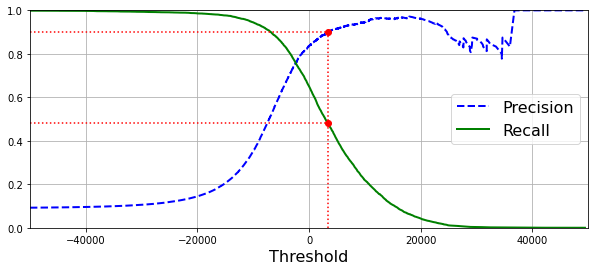

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(10, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                          # Not shown
plt.show()

But why is the precision curve much more bumpier than the recall curve, sometimes precision will go up and down when we raise the threshold. This might be because raising the precision takes it from 4/5 which is 80% to 3/4 which is 75% whereas recall can only go down when we raise the threshold. 

Another good way to select a good precision recall tradeoff is to plot the precision directly against the recall. 

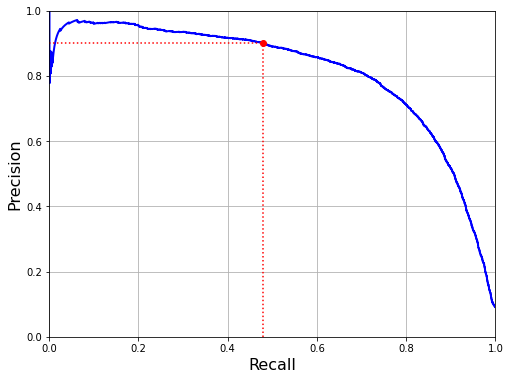

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

What can we see from this graph, we can see that after around 0.6 recall, we get a really big drop in precision. This means we will most likely want to set the recall rate to 0.6 as anymore and we will loose any form of precision we had in the system, but really **the choice depends on the project at hand**. Suppose we want to aim for about 90% precision, we look at the first plot we made and find that we need to use a threshold of about 8000. To be more precise, we can search for the lowest threshold that gives us at least 90% precision using **np.argmax()** this will give us the first index of the maximum value, which in this case is the first true value. 

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

To make predicitions (on the training set for now) instead of calling the classifiers **predict()** method like ususal we will run this code. 

In [30]:
y_training_90_predict = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_training_90_predict)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_training_90_predict)

0.4799852425751706

We now have a 90% precise classifier, as we can see it is sort of easy to make our own classifier with custom precision and recall scores. All we need to do is set the threshold high enough or low enough and we will reach it. But remember that a high precision classifier is useless without good recall!!!!!

### ROC Curve 

The **reciever operator characteristic (ROC)** curve is another tool that machine learning engineers use with binary classifiers. It is very similar to the **precision recall** curve, but instead of plotting precision vs recall the **ROC** curve plots the true positive rate (TPR) vs the false positive rate (FPR). Note that TRP is another word for recall. The FPR is the ratio of negatie instances that are incorrectly identified as positive instances. This is equal the 1 - the true negative rate, which is the negative instances correctly indentified as negative. The TNR is also called specificity. Which is why the ROC has also earned the name sensitivity vs 1- specificity.

To plot the ROC curve we first need to use the **roc_curve()** function to compute the TPR and FPR for various thresholds

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

This allows us to plot the ROC curve using matplotlib.

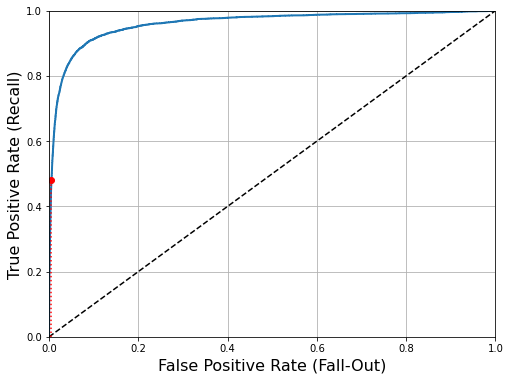

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                 
plt.show()

Like before, there is still a trad eoff between a higher recall (TPR) and the more false positives we introduce (FPR). The dotted line represents the ROC of a purely random classifier, a good classifier always stays far away from this line, the more toward the top left corner the better. 

One way commonly used to compare classifiers is the **area under the curve (AUC)**. A perfect classifier will have an AUC of 1, whereas a random classifier will have an AUC 0.5. Scikit learn provides us with a function to compute the AUC of an ROC curve

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

But since the ROC curve and the precision recall curve to practically the same thing, how do we know which one to choose??? As a rule of thumb. We should use the PR curve whenever a positive instance is rare or when we care more about the flase positive than the false negatives, BUT when we care more about the false negatives, we should use the ROC curve. Like above, we might say that this classifier is really good when looking at the ROC curve, but when we find that positive instances are really rare (the 5's) this ROC curve becomes a little less fantastic....

How lets train a random forest classifier and compare the random forests classifiers ROC to the SGD ROC. To do this we need to get the scores for each instance in the training set but due to the way a RF works (we will explore in chapter 7) the RF does not have a **decision_function()** method. Instead, it uses a **predict_proba()** function that outputs an array containing a row per instance and a columns per class, each containing the probability that the instace belongs in the given class (70% chance that the image belongs to the 5 class) 

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method='predict_proba')

The ROC curve function expects labels and scores, but we can also feed it class probabilities. Lets use the positive classes probability as the score for the ROC curve.

In [37]:
y_forest_scores = y_probas_forest[:, 1] #This sets the score to equal the probability of being in the positive class


In [38]:
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_train_5, y_forest_scores)

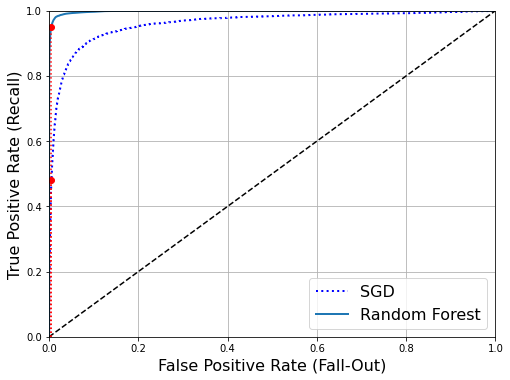

In [39]:
recall_for_forest = forest_tpr[np.argmax(forest_fpr >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(forest_fpr, forest_tpr, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Comparing the two, we can see that the RF classifier is a much better as it has a much greater AUC when compared to the SGD classifier. 

In [40]:
roc_auc_score(y_train_5, y_forest_scores)

0.9983436731328145

When we measure the precision and the recall scores, we will find that we get 99% precision and 86% recall thats really good!

We now know how to train a binary classifier, choose the most appropriate metric for our task, evaluate our classifier using cross validation, selecting the precision recall curve (when positive instance numbers are small or we favour looking at false positives over false negatives or the ROC curve (everything else) depending on what we want to use the classifier for and compare different models. 

Now lets try some multioutput classification. 

### Multioutput Classification

Binary classification is where we are comparing against two classes, **multiclass classifiers** can distinguish between more than two classes. Some algorithms such as SGD, RF and naive bayes classifiers are capabale of handling multiple classes nativly. Other such as logistic regression and support vector machines are strictly binary classifiers (but we can find work arounds, lets explore them) 

One way to create a work around to create a system that can classify the digit images into 10 classes is to create 10 classifiers (from 0 to 10) one for each digit. Then when we want to classify an image we need to get the decision score from each classifier for that image and we select the class whos classifier outputs the highest score. This is called **one vs rest** classification, or **one vs all** classification.

Another strategy is to train the a binary classifier for every pair of digits, one to distignish between 0 and 1, the next to distinguish between 0 and 2, another to distinguish between 1 and 2 and so on and so on. This is called **one vs one** strategy, if there is $N$ number of classes we need $N (N -1) / 2$ classifiers so our needed classifier number increases massively. For the MNST problem this means training 45 binary classifiers, which is a pain in the ass but from those 45 classifiers, we simply see which class wins the most duals. The main advatage of One vs One classification is that each classifier only needs to be trained on part of the training set fro the two classes that it must distinguish. 

Some algorithms such as support vector machines scale really poorly with the size of the training set, for these algorithms OvO classification is perfect because it is faster to train many classifiers on small training sets than to train a few classifiers on bigger sets of training data. However for most binary classifcation algorithms OvR is preferred. 

Scikit-learn automatically detects when we are using a binary classifier for a mutliclassification task and it will run OvR or OvO depending on the algorithm. Lets try a SVM classifier using the sklearn.svm.SVC class. 

In [41]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) #not y train 5
svm_clf.predict([first_digit])

array([5], dtype=uint8)

That was easy, the code above trains the SVC on the training data set using the original target classes from 0 to 9 (y_train) instead of the 5 vs the rest classes. Then it makes a prediction, correctly! Under the hood scikit learn actually used one vs one strategy it has trained 45 binary classifiers got the decision scores for the image and selected the class that won the duals. 

If we call the **decision_function()** method you will see that it returns 10 scores for each instance, one score per class (10).



In [42]:
some_digit_scores = svm_clf.decision_function([first_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score of course correlates to class number 5. 


In [43]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

When a classifier is trained, it stores the list of target classes in its **classes_** attribute, ordered by the value, in this case the index of each class just happens to match the class number itself!!! but in general we won't be so lucky. 

If we want to force Scikit-learn to use one vs one or one vs rest you can used the **OneVsOneClassifier** or **OneVsRestClassifier** classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier) for example, the code below creates a mutliclass classifier using the OvR strategy based on a SVC

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC()) # Here we pass the classifier into the One vs Rest classifier constructor
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([first_digit])

array([5], dtype=uint8)

In [51]:
len(ovr_clf.estimators_)

10

Training a SGD classifier is just as easy.

In [48]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([first_digit])

array([3], dtype=uint8)

In [52]:
sgd_clf.decision_function([first_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

As we can see, this time scikit learn did not have to run one vs rest or one vs one classification as an SGD classifier can natively handle mutlioutput classification. We can also see that the classifier actaully got the prediciton WRONG (this is not in the book) and predicts that the image is actually a 3 and not a 5! This model is Now we want to evaluate this classifier, we can do this using cross validation using the **cross_val_score()** method to evaluate the classifiers accuracy. 

In [54]:
cross_val_score(sgd_clf, X_train, y_train)

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

It gets over x% on all of the testing folds (not the test set). If we were to use a random classifier, we would get around 10% the book says, so this is great progress. However, we can still do so much better, if we were to scale the input data we could boost our performance!

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # astype allows us to change the type of data we are using
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

If this was a real life project, we would go through our machine learning checklist and explore data preparation options, try out multiple models, then shortlisting a few promising ones and tuning their hyperparameters (all the time trying to automate this as much as possible. Another way to find imporvements in models is the analyse the mistakes that the model is making.

First lets look at a confusion matrix. To do this we need to make predicitions using the **cross_val_predict()** method not the **cross_val_score()**. Then we can call the **confusion_matrix()** function that will compute the confusion matrix for us. 

In [60]:
y_train_prediction = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [102]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_prediction)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

Thats a lot of numbers, it is often a lot easier to visualise what the model is doing using matplotlibs matshow() function, this will produce a heatmap of the confusion matrix. 

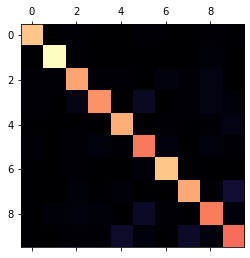

In [103]:
plt.matshow(conf_mx, cmap='magma')

We can see that the confusion matrix looks pretty good, most of the images are on the main diagonal which means they are being classified correctly. The 5s and the 9s look a little bit darker than the rest of them however. This could be for two reasons, the first being there is just fewer of them in the training set, the second is that we are making more errors on these. We can verify that both are the case. 

Lets focus on the errors for now. To do this we are going to **divide each value in the confusion matrix by the total number of images in the corresponding class** this allows us to compare the error rates instead of the absolute numbers of errors, which would make abundent classes look unfairly bad. 

In [105]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

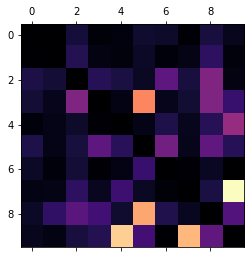

In [107]:
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap='magma')
plt.show()

We can now clearly see where the classifier is making mistakes. Remeber that the rows are the True values and the columns are the predicted values, so we can see that rather often our classifier will predict 5 when infact it is actually a 3. We can also see that it is struggling a lot with 8s it seems to predict everything is an 8 at some point, but doesnt predict a 6 to be an 8. 

Analysing the confusion matrix often gives us insights into ways to improve our model, looking at our plot we can see that 8s are clearly the worst performing number, so it might be worth going away and finding more 8s and numbers that look like 8s but actually are not 8s to train our model on. Or we could engineer some new features that would help the classifer. For example we could write an algorithm to count the number of closed loops (8 has 2, 6 has 1). Or we could preprocess the images using **Scikit-Image, Pillow, OpenCV** to make some patterns such as closed loops easier to see. 

Analyzing individual errors can also be a good way to gain insights on what our classifier is doing and why it is failing in areas, but it is more difficult to do. 

For example lets plot examples of 3's and 5's using the **plot_digits()** function.

In [130]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

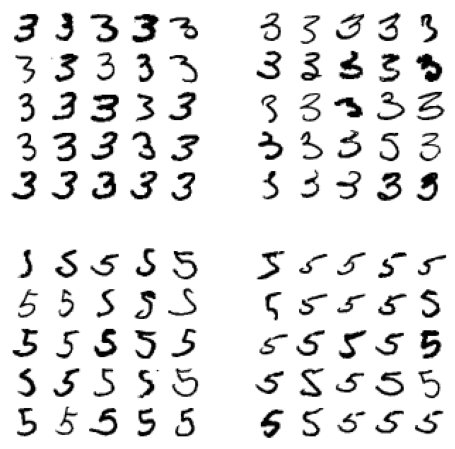

In [114]:
import matplotlib

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_prediction == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_prediction == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_prediction == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_prediction == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two blocks on the left show digits that have been classified as 3s, and the two blocks on the right show what digits have been classified as 5s. Some digits as we can see have been missclassified. Some are really badly written like the digit on the top left of the lower left block. Others like the 5 appear to be in the 5s classification but in the misclassified box which is strange. But most of them are rather clear so why is our classifier making this error, the reason is that we are using a rather basic model, a SGD classifier is a linear classifier and all it does is assign a weight per class to each pixel, and when it gets a new instance all it does is add up all of the weighted pixel intensities and get a score for each class. So the 3s and 5s only differing in a few parts is enough to throw the algorithm off its stride. 

The main difference between the 5s and the 3s is the position of the small line at the top that joins the top lines together, the 5 is vertical whereas the 3 is horizontal, if we draw the 3 junction slightly more vertical, we can start to see how the classifier is getting it wrong. In other words the classifier is really sensitive to image rotation, so one way to reduce the confusion between the two digits would be to center all of the images and make sure that they are not rotated too much. This will most likely help reduce the errors that the classifier is making. 

### Mutlilabel Classification 

Unti now each instance has always been assinged to just one class, in some cases you may want our classifier to output multiple classes for each single instance. Consider a face recognition classifier, what should it do if it recognises several people in the same picture? It should attach one tag per person it recognises. Say the classifier has been trained to recognise three faces, Alic, Bob and Charlie. Then when the classifier is shown a picture of Alice and Charlie it should output $[1,0,1]$. Meaning that Alice is in the photo, Bob is not and Charlie is in the photo. Such a classification system that outputs multiple binary tags is called a **multilabel classification system** 

We are not going into facial recognition just yet (thank god ahahah), but lets consider another example

In [117]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

The code above creates a y_mutlilabel array that contains the two target for labels for each digit image, the first indicates whether or not the digit is larger (7,8,9) and the second indicated whether it is odd or even. The next lines create a KNeighborsClassifier instance (this supports mutlilabel classification, not all classifiers do), and we then train it used the multiple targets array (y_multilabel). Now we can make a predicition and notice that there are two output labels

In [119]:
knn_clf.predict([first_digit])

array([[False,  True]])

And the classifier gets it right! The digit is a 5, and is indeed not larger than 7, and it is odd (False, True). 

There are many ways to evaluate a mutlilabel classifier, and selecting the right metric really depends on the project we are doing. One approach is the measure the $F_1$ score for each individual label (or any other binary classifier metric we have spoken about earlier), then we can compute the average score across the labels. 

In [121]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

This code assumes that all labels are equally important, however, which may not be the case, if you have many more pictures of Alice than Bob and Charlie, we may want to give **more weight** to the classifers score on pictures of Alice. One simple option is to give each label a weight equal to its **support** (i.e the number of instances with that target label). To do this simply set **average == 'weighted'** in the preceding code.


### Multioutput Classification

The last type of classification we are going to talk about is **multioutput  multiclass classification** or simply **mutlioutput classification**. This type of classification is simply where mutlilabel classification can be multiclass (ie it can have more than two possible values)

To illistrate this point we are going to create a system that removes noise from images and output a clean image. represented as an array of pixel itensities, just like the MNIST images. Notice that the classifiers output is mutlilabel (one label per pixel) and each label can have multiple values (pixel intensities ranging from 0 to 255). So we can have many labels and many values of that label. It is thsu an example of a mutlioutput classification. 

Sometimes the line between classification and regression is sometimes really blurry. Arguably predicting pixel intensitiy is more akin to regression than to classification. Moreover multioutput systems are not limited to classification tasks, we could even have a system that outputs multiple labels per instance, including both class labels and value labels. 

Lets start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPys **randint()** function. The target images will be the original images. 

In [148]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Lets take a peek at an image from the test set (we are snooping, this is usually not allowed lol)

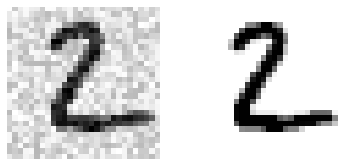

In [149]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 1
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

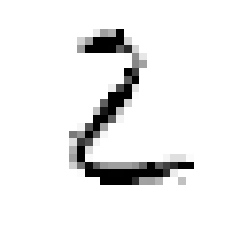

In [150]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Originally I had made a mistake with the code which gave the model no chance for it to work (I was setting the training data to simply be just random noise. After revewing the code, I have corrected it and it works!!!!

In this chapter, we have learned how to evaluate models in classification tasks, compare classifiers and build a good classification system. 